# Récupération des données de review anglais et français

Basé sur le fichier kaggle suivant : https://www.kaggle.com/datasets/kieranpoc/steam-reviews/data

## Import des librairies

In [38]:
import numpy as np
import pandas as pd
import os
import matplotlib.pyplot as plt
import seaborn as sns
import re

import kagglehub

## Méthodes utiles

In [39]:
def column_summary(df: pd.DataFrame):
    summary = []
    for col in df.columns:
        col_type = df[col].dtype
        non_null = df[col].notna().sum()
        null_count = df[col].isna().sum()
        
        # Gérer le cas où la colonne contient des listes (unhashable)
        try:
            unique_count = df[col].nunique()
        except TypeError:
            # Si erreur (listes), convertir en string temporairement
            unique_count = df[col].astype(str).nunique()
            print(f"⚠️ Colonne '{col}' contient des types non-hashable (probablement des listes)")

        summary.append({
            'Column': col,
            'Type': str(col_type),
            'Non-Null Count': non_null,
            'Null Count': null_count,
            'Unique Values': unique_count,
        })

    # Afficher le résumé des colonnes
    print("=" * 80)
    print("Résumé détaillé des colonnes:")
    print("=" * 80)
    column_summary_df = pd.DataFrame(summary)
    print(column_summary_df.to_string(index=False))
    print("\n")

In [40]:
def print_voted_up_count_proportion(df:pd.DataFrame):
    voted_up_counts = df['voted_up'].value_counts()
    total_reviews = len(df)
    
    print("voted_up (reviews positive:1 / negative:0)")
    for voted_up_value, count in voted_up_counts.items():
        proportion = (count / total_reviews) * 100    
        print(f"voted_up = {voted_up_value}: Count = {count}, Proportion = {proportion:.2f}%")

    print(f"\nPour obtenir une distribution équilibrée 50/50, en sous échantillonnant la classe majoritaire\n")
    print(f"On aurait {min(voted_up_counts)} reviews par classe. Soit un total de {2 * min(voted_up_counts)} reviews.")

## Téléchargement à partir de kaggle hub

In [41]:
# Download latest version
path = kagglehub.dataset_download("kieranpoc/steam-reviews")

print("Path to dataset files:", path)

Path to dataset files: /home/sebas/.cache/kagglehub/datasets/kieranpoc/steam-reviews/versions/2


On a ici deux fichiers:

- un fichier contenant 100 millions de reviews de jeux vidéo postés sur le marketplace steam, multi langue (40GB)
- un second fichier plus léger extrait du premier de 500 milles reviews steam ayant un score de crédibilité élevé (weighted_vote_score > 0.8)

## Analyse du fichier des 500 000 reviews avec un score de crédibilité/utilité steam élevé

weighted_vote_score > 0.8 : Valve a mis en place un système de pondération pour éviter que des campagnes coordonnées (bots ou groupes) 
ne manipulent les reviews mises en avant. 

- Ce n'est pas un indicateur de sentiment (positif/négatif)
- C'est un score de crédibilité/utilité de la review

Filtre des review générées par des bots

- Les reviews de bots sont souvent génériques, peu votées, donc score faible
- Une review avec un score élevé a été validée par de vrais utilisateurs
- Filtrer les scores très bas (proche de 0) peut éliminer du spam (ici 0.8 marge confortable)

In [42]:
df_reviews = pd.read_csv(
    f"{path}/weighted_score_above_08.csv",
    # usecols=['appid', 'game', 'language', 'review','voted_up'],  # Specify only the needed columns
    low_memory=True  # Optimize memory usage
)

df_reviews.head()

/tmp/ipykernel_1152/3081908739.py:1: DtypeWarning: Columns (23) have mixed types. Specify dtype option on import or set low_memory=False.
  df_reviews = pd.read_csv(


,recommendationid,appid,game,author_steamid,author_num_games_owned,author_num_reviews,author_playtime_forever,author_playtime_last_two_weeks,author_playtime_at_review,author_last_played,...,voted_up,votes_up,votes_funny,weighted_vote_score,comment_count,steam_purchase,received_for_free,written_during_early_access,hidden_in_steam_china,steam_china_location
0,147449116,10,Counter-Strike,76561199183984450,51,12,2548,0,2480,1696305457,...,1,99,2,0.889438,0,1,0,0,1,NaN
1,147374264,10,Counter-Strike,76561198099573060,226,13,2369,0,2361,1696096555,...,1,122,8,0.914834,0,1,0,0,1,NaN
2,147357703,10,Counter-Strike,76561199080026894,118,23,13501,212,12957,1697630734,...,1,599,20,0.968375,3,1,0,0,1,NaN
3,147345102,10,Counter-Strike,76561198068970227,28,1,10668,640,9906,1698261011,...,1,59,12,0.826206,0,0,0,0,1,NaN
4,147284743,10,Counter-Strike,76561199137893460,19,5,543,10,526,1697810991,...,1,128,24,0.853612,0,1,0,0,1,NaN


In [43]:
column_summary(df_reviews)

Résumé détaillé des colonnes:
                        Column    Type  Non-Null Count  Null Count  Unique Values
              recommendationid   int64          498094           0         496233
                         appid   int64          498094           0          27315
                          game  object          498061          33          27261
                author_steamid   int64          498094           0         379636
        author_num_games_owned   int64          498094           0           5387
            author_num_reviews   int64          498094           0            911
       author_playtime_forever   int64          498094           0          65213
author_playtime_last_two_weeks   int64          498094           0           5065
     author_playtime_at_review   int64          498094           0          46691
            author_last_played   int64          498094           0         464661
                      language  object          498094           0  

In [44]:
df_reviews['language'].value_counts()

language
english       193174
schinese      160121
russian        50558
spanish        16080
brazilian      15092
turkish        13848
koreana        11901
japanese        7339
german          6759
tchinese        5458
french          5285
polish          4399
ukrainian       2715
latam           1378
italian         1346
thai            1007
czech            824
hungarian        419
portuguese       209
romanian          38
finnish           34
vietnamese        32
dutch             18
swedish           16
bulgarian         14
norwegian         13
danish             9
greek              8
Name: count, dtype: int64

In [45]:
print_voted_up_count_proportion(df_reviews)

voted_up (reviews positive:1 / negative:0)
voted_up = 1: Count = 420592, Proportion = 84.44%
voted_up = 0: Count = 77502, Proportion = 15.56%

Pour obtenir une distribution équilibrée 50/50, en sous échantillonnant la classe majoritaire

On aurait 77502 reviews par classe. Soit un total de 155004 reviews.


## Analyse des reviews anglaises (pour fine tuning BERT Standard)

In [46]:
df_review_en = df_reviews[df_reviews["language"] == "english"]
df_review_en.head(5)

,recommendationid,appid,game,author_steamid,author_num_games_owned,author_num_reviews,author_playtime_forever,author_playtime_last_two_weeks,author_playtime_at_review,author_last_played,...,voted_up,votes_up,votes_funny,weighted_vote_score,comment_count,steam_purchase,received_for_free,written_during_early_access,hidden_in_steam_china,steam_china_location
5,147263134,10,Counter-Strike,76561199013220131,41,10,2510,0,221,1696768614,...,1,300,13,0.863652,0,1,0,0,1,NaN
9,146253831,10,Counter-Strike,76561198847956367,0,1,404175,1486,396410,1698293849,...,1,102,1,0.865922,0,1,0,0,1,NaN
17,145002893,10,Counter-Strike,76561198995972388,50,50,81,0,81,1692978815,...,1,208,31,0.935513,0,1,0,0,1,NaN
23,144308037,10,Counter-Strike,76561198893691388,11,5,89,10,78,1698145024,...,1,367,19,0.875650,11,1,0,0,1,NaN
27,142806143,10,Counter-Strike,76561198200827945,0,27,26583,1,26568,1697487613,...,1,90,2,0.877432,0,1,0,0,1,NaN


In [47]:
column_summary(df_review_en)

Résumé détaillé des colonnes:
                        Column    Type  Non-Null Count  Null Count  Unique Values
              recommendationid   int64          193174           0         192198
                         appid   int64          193174           0          21923
                          game  object          193162          12          21888
                author_steamid   int64          193174           0         152763
        author_num_games_owned   int64          193174           0           4081
            author_num_reviews   int64          193174           0            696
       author_playtime_forever   int64          193174           0          38002
author_playtime_last_two_weeks   int64          193174           0           3382
     author_playtime_at_review   int64          193174           0          28781
            author_last_played   int64          193174           0         176702
                      language  object          193174           0  

In [48]:
print_voted_up_count_proportion(df_review_en)

voted_up (reviews positive:1 / negative:0)
voted_up = 1: Count = 155952, Proportion = 80.73%
voted_up = 0: Count = 37222, Proportion = 19.27%

Pour obtenir une distribution équilibrée 50/50, en sous échantillonnant la classe majoritaire

On aurait 37222 reviews par classe. Soit un total de 74444 reviews.


## Taille des reviews anglaise

Keras NLP va tronquer les textes trop long.Une bonne stratégie peut également de Garder début + fin.

Si les textes sont trop court, l'entrainement peut être bruité.

Pour filtrer les tailles de reviews création de paramétre dans le pipeline final (comparer les résultats)

In [ ]:
# Création des paramètres de filtrage des reviews par taille

TEXT_WORD_MIN_LENGTH = 5
TEXT_WORD_MAX_LENGTH = 500

In [ ]:
# Si stratégie de garder début + fin
def truncate_middle(text, max_words=400):
    words = text.split()
    if len(words) <= max_words:
        return text
    half = max_words // 2
    return ' '.join(words[:half] + words[-half:])

In [50]:
# Statistiques de longueur
texts = df_review_en['review'].tolist()
text_lengths = [len(text.split()) for text in texts]

print(f"\nLongueur min: {np.min(text_lengths):.0f} mots")
print(f"\nLongueur max: {np.max(text_lengths):.0f} mots")
print(f"\nLongueur moyenne des reviews: {np.mean(text_lengths):.0f} mots")


Longueur min: 0 mots

Longueur max: 2662 mots

Longueur moyenne des reviews: 190 mots


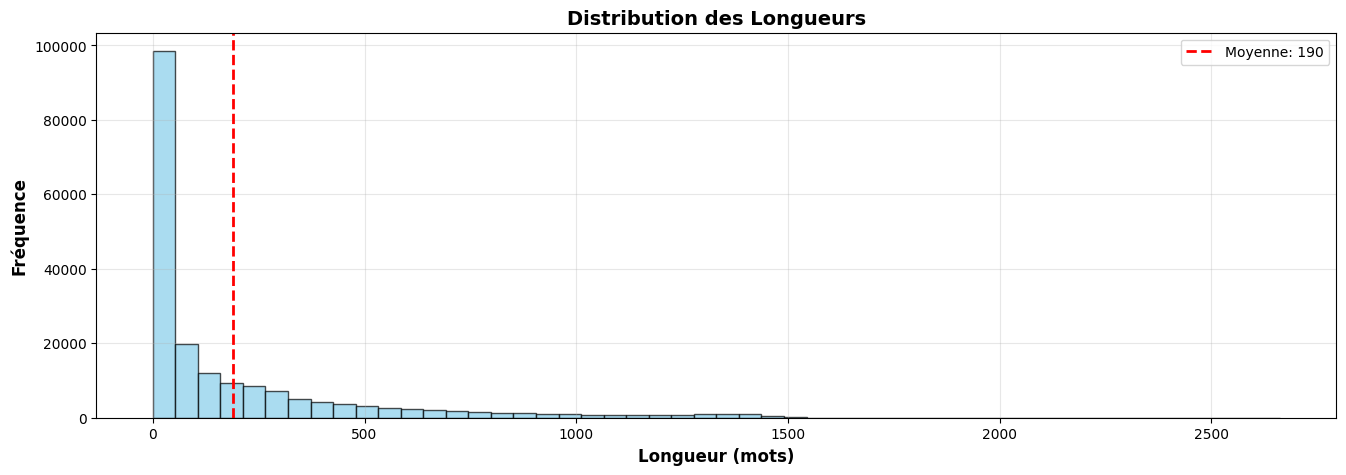

In [51]:
fig, (ax1) = plt.subplots(1, 1, figsize=(16, 5))

ax1: plt.Axes
# Distribution des longueurs
ax1.hist(text_lengths, bins=50, edgecolor='black', alpha=0.7, color='skyblue')
ax1.axvline(np.mean(text_lengths), color='red', linestyle='--', linewidth=2, 
            label=f'Moyenne: {np.mean(text_lengths):.0f}')
ax1.set_xlabel('Longueur (mots)', fontsize=12, fontweight='bold')
ax1.set_ylabel('Fréquence', fontsize=12, fontweight='bold')
ax1.set_title('Distribution des Longueurs', fontsize=14, fontweight='bold')
ax1.legend()
ax1.grid(alpha=0.3)

In [52]:
df_review_en_stats = df_review_en.copy()
df_review_en_stats.loc[:, 'word_count'] = df_review_en_stats['review'].str.split().str.len()

# Analyser taille idéale
df_ideal_size_en = df_review_en_stats[(df_review_en_stats['word_count'] >= TEXT_WORD_MIN_LENGTH) & (df_review_en_stats['word_count'] <= TEXT_WORD_MAX_LENGTH)]
print(f"Reviews totales : {len(df_review_en_stats)}")
print(f"Reviews taille idéale : {len(df_ideal_size_en)}")
print(f"Pourcentage : {len(df_ideal_size_en)/len(df_review_en_stats)*100:.1f}%")

Reviews totales : 193174
Reviews taille idéale : 139073
Pourcentage : 72.0%


In [53]:
# Distribution par tranches
df_review_en_stats_dist = df_review_en_stats.copy()
bins = [0, 10, 20, 50, 100, 300, 512, float('inf')]
labels = ['<10', '10-20', '20-50', '50-100', '100-300', '300-512', '>512']
df_review_en_stats_dist['tranche'] = pd.cut(df_review_en_stats_dist['word_count'], bins=bins, labels=labels)

print('Affichage de toute les tranches de longueurs:')
print(df_review_en_stats_dist['tranche'].value_counts().sort_index())

Affichage de toute les tranches de longueurs:
tranche
<10        41874
10-20      26810
20-50      28258
50-100     19686
100-300    36630
300-512    17022
>512       22886
Name: count, dtype: int64


Affichage du nombre de review sentiment positif et négatif

In [54]:
print_voted_up_count_proportion(df_ideal_size_en)

voted_up (reviews positive:1 / negative:0)
voted_up = 1: Count = 114025, Proportion = 81.99%
voted_up = 0: Count = 25048, Proportion = 18.01%

Pour obtenir une distribution équilibrée 50/50, en sous échantillonnant la classe majoritaire

On aurait 25048 reviews par classe. Soit un total de 50096 reviews.


## Pertinance des reviews à partir des features de contexte

Filtre des reviews pour essayer de minimiser les reviews truqués ou généré par des bots.
On veut entrainer le modèle avec des reviews crées par des joueurs légitimes et surtout non synthetique.

Les features importantes : 
- votes_up : le nombre de joueur ayant up vote la review (la trouvant pertinante)
- author_playtime_forever : temps de jeu du joueur sur le jeu commenté
- steam_purchase : le jeu a été acheté achat vérifié
- received_for_free : le jeu a été obtenu gratuitement (tendance a être moins regardant)

L'objectif dans un premier temps est d'utiliser du transfert learning et du fine tuning sur BERT.

Pour simplifier la démarche, les features supplémentaire ne seront pas utilisé lors de l'entrainement.

In [55]:
features_to_explore = [
    "votes_up",
    "author_playtime_forever",
]

stats = pd.DataFrame({
    'mean': df_ideal_size_en[features_to_explore].mean(),
    'min': df_ideal_size_en[features_to_explore].min(),
    'median': df_ideal_size_en[features_to_explore].median(),
    'max': df_ideal_size_en[features_to_explore].max(),
    'zeros_%': ((df_ideal_size_en[features_to_explore] == 0).sum() / len(df_ideal_size_en) * 100).round(1)
})

print(stats)

for feat in ['steam_purchase', 'received_for_free']:
    counts = df_ideal_size_en[feat].value_counts()
    pcts = df_ideal_size_en[feat].value_counts(normalize=True) * 100
    
    print(f"\n{feat}:")
    print(f"  0: {counts.get(0, 0):,} ({pcts.get(0, 0):.1f}%)")
    print(f"  1: {counts.get(1, 0):,} ({pcts.get(1, 0):.1f}%)")

                                 mean  min  median      max  zeros_%
votes_up                   240.151597    0   117.0    62199      0.2
author_playtime_forever  18549.124676    0  1089.0  5440698      8.8

steam_purchase:
  0: 43,613 (31.4%)
  1: 95,460 (68.6%)

received_for_free:
  0: 135,050 (97.1%)
  1: 4,023 (2.9%)


## Weighted score verification

In [56]:
correlations = df_ideal_size_en.select_dtypes(include='number').corrwith(
    df_ideal_size_en['weighted_vote_score'],
    method='spearman'
).sort_values(ascending=False)

pd.DataFrame({
    'abs_correlation': correlations.abs()
}).sort_values('abs_correlation', ascending=False)

,abs_correlation
weighted_vote_score,1.000000
votes_up,0.627251
votes_funny,0.272715
comment_count,0.131345
author_last_played,0.072600
voted_up,0.064775
timestamp_updated,0.063883
timestamp_created,0.063345
recommendationid,0.063345
appid,0.056726


## Filtres pour garder les reviews les plus légitimes

In [57]:
df_clean = df_reviews.copy()

In [58]:
df_clean.loc[:, 'word_count'] = df_clean['review'].str.split().str.len() # Création de la colonne word_count

In [59]:
def clean_review_to_keep_legitimate(df:pd.DataFrame):
    df_clean = df[
        (df['steam_purchase'] == 1) &           # Achat vérifié
        (df['received_for_free'] == 0) &        # Pas reçu gratuitement
        (df['author_playtime_forever'] > 20) &  # Au moins 20 minutes de jeu
        (df['word_count'] >= TEXT_WORD_MIN_LENGTH) &              # Review pas trop courte
        (df["language"] == "english")
    ]
    
    return df_clean

In [60]:
df_clean = clean_review_to_keep_legitimate(df_clean)

# Stats
print_voted_up_count_proportion(df_clean)

voted_up (reviews positive:1 / negative:0)
voted_up = 1: Count = 89398, Proportion = 82.64%
voted_up = 0: Count = 18777, Proportion = 17.36%

Pour obtenir une distribution équilibrée 50/50, en sous échantillonnant la classe majoritaire

On aurait 18777 reviews par classe. Soit un total de 37554 reviews.


En filtrant un peu plus les reviews on arrive toujours à en obtenir un nombre suffisant pour l'entrainement du modèle

## Vérification de la forme des reviews et de leur sentiment positive / négative

In [61]:
df_check_voted_up = df_reviews.copy()

In [62]:
df_check_voted_up.loc[:, 'word_count'] = df_check_voted_up['review'].str.split().str.len() # Création de la colonne word_count

In [63]:
# on ne garde que les reviews en anglais
df_check_voted_up = df_check_voted_up[df_check_voted_up["language"] == "english"]

### Détection ASCII Art

Certaines reviews ne contiennent pas du tout de mots mais sont de type ASCII Art 
https://fr.wikipedia.org/wiki/Art_ASCII


Pour éviter de bruiter l'entrainement je préfère les enlever dans un premier temps.

In [64]:
def has_enough_letters(text: str, min_ratio=0.5):
    
    if not isinstance(text, str) or len(text) == 0:
        return False
    
    letters = sum(c.isalpha() for c in text)
    return (letters / len(text)) >= min_ratio

In [65]:
# Voir quelques exemples de reviews filtrées
removed = df_check_voted_up[~df_check_voted_up['review'].apply(has_enough_letters)]

print(f"Reviews supprimées : {len(removed)}")

for review in removed['review'].head(10):
    print(review[:100])
    print("---")

Reviews supprimées : 4421
cs 1.6>cs2
---
Here I will leave the cat, friends who pass by can pet it and give it a thumbs up 　　　 　　／＞　　フ 　　　 　　
---
best game in the solar system  ⣿⣿⣿⣿⣿⣿⣿⣿⡿⠿⠛⠛⠛⠋⠉⠈⠉⠉⠉⠉⠛⠻⢿⣿⣿⣿⣿⣿⣿⣿ ⣿⣿⣿⣿⣿⡿⠋⠁⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠉⠛⢿⣿⣿⣿⣿ ⣿⣿⣿⣿⡏⣀⠀
---
Here I will leave the cat, friends who pass by can pet it and give it a thumbs up 　　　 　　／＞　　フ 　　　 　　
---
Players who's still play this game: ⣿⣿⣿⣿⣿⣿⣿⣿⡿⠿⠛⠛⠛⠋⠉⠈⠉⠉⠉⠉⠛⠻⢿⣿⣿⣿⣿⣿⣿⣿ ⣿⣿⣿⣿⣿⡿⠋⠁⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠉⠛⢿⣿⣿⣿⣿ ⣿⣿
---
Yes, this is my favorite game. How could you tell?  ⣿⣿⣿⣿⣿⣿⣿⣿⡿⠿⠛⠛⠛⠋⠉⠈⠉⠉⠉⠉⠛⠻⢿⣿⣿⣿⣿⣿⣿⣿ ⣿⣿⣿⣿⣿⡿⠋⠁⠀⠀⠀⠀⠀⠀⠀⠀⠀
---
people who still play this game ⣿⣿⣿⣿⣿⣿⣿⣿⡿⠿⠛⠛⠛⠋⠉⠈⠉⠉⠉⠉⠛⠻⢿⣿⣿⣿⣿⣿⣿⣿ ⣿⣿⣿⣿⣿⡿⠋⠁⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠉⠛⢿⣿⣿⣿⣿ ⣿⣿⣿⣿⡏⣀
---
⣿⣿⣿⣿⣿⣿⣿⣿⡿⠿⠛⠛⠛⠋⠉⠈⠉⠉⠉⠉⠛⠻⢿⣿⣿⣿⣿⣿⣿⣿ ⣿⣿⣿⣿⣿⡿⠋⠁⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠉⠛⢿⣿⣿⣿⣿ ⣿⣿⣿⣿⡏⣀⠀⠀⠀⠀⠀⠀⠀⣀⣤⣤⣤⣄⡀⠀⠀⠀⠀⠀⠀⠀⠙⢿⣿⣿ ⣿⣿⣿⢏⣴⣿⣷
---
⣿⣿⣿⣿⣿⣿⣿⡿⠟⠛⠉⠉⠉⠉⠋⠉⠉⠙⠛⠛⠻⠿⢿⣿⣿⣿⣿⣿⣿⣿ ⣿⣿⣿⣿⠿⠋⠁⠄⠄⠄⠄⠄⠄⠄⠄⠄⠄⠄⠄⠄⠄⠄⠈⠉⠻⣿⣿⣿⣿⣿ ⣿⣿⡟⠁⠄⠄⠄⠄⠄⠄⠄⠄⠄⠄⠄⠄⠄⠄⠄⠄⠄⠄⠄⠄⠄⠙⢻⣿⣿⣿ ⣿⠏⠄⠄⠄⠄⠄
---
[h1] [b] ALL TIME BEST! [/b] [/h1]
---


In [66]:
# On les supprime pour le reste de l'analyse des reviews
df_clean = df_check_voted_up[df_check_voted_up['review'].apply(has_enough_letters)]

print(f"Avant : {len(df_check_voted_up)}")
print(f"Après : {len(df_clean)}")

df_check_voted_up = df_clean

Avant : 193174
Après : 188753


### Notes sur la gestion des émojis/émoticônes

BERT gère déjà les émojis/émoticônes. Son tokenizer les traite comme des tokens inconnus ou les décompose, mais le contexte autour suffit généralement.

On va filtrer la longueur pour avoir minimum 10 mots. Le texte autour de l'émojis porte l'essentiel du signal positif ou négatif.

A noter que BERT/KerasNLP gère ça :

- Le tokenizer les traite comme tokens inconnus [UNK] ou les décompose
- Le contexte autour compense

In [67]:
# Pour test ultérieur, transformation des émojis en texte simple

emoticons = {
    r':\)|:-\)|=\)': ' sourire ',
    r':\(|:-\(|=\(': ' triste ',
    r":\'\(": ' pleure ',
    r';\)|;-\)': ' clin_oeil ',
    r':D|:-D|=D': ' rire ',
    r'XD': ' mort_de_rire ',
    r':P|:-P|=P': ' tire_langue ',
}

def replace_emoticons(text):
    for pattern, replacement in emoticons.items():
        text = re.sub(pattern, replacement, text)
    return text

# Sur la même problématique, on peut aussi envisager d'utiliser des librairies comme 'emoji' pour une gestion plus complète des émojis.
# Par exemple :
# import emoji
# def replace_emojis(text):
#     return emoji.demojize(text, delimiters=(" ", " "))        

# Dictionnaire simple pour quelques symbols courants
symbols = {
    '♥': ' love ',
    '★': ' star ',
    '☆': ' star ',
    '♫': ' music ',
    '✓': ' ok ',
    '✗': ' no ',
    '👍': ' good ',
    '👎': ' bad ',
}

def replace_symbols(text):
    for symbol, word in symbols.items():
        text = text.replace(symbol, word)
    return text

### Notes gestion HTML/BBCode

Comme vu lors de la formation, keras NLP la librairie que je vais utiliser contient une phase preprocess des phrases.

Il peut quand même être bénéfiques de supprimer en amont les balises html des reviews :
- Limite 512 tokens atteinte plus vite
- Si keras NLP garde les balises, cela peut créer du bruit / signal moin net.

In [68]:
# Pour la suite de l'analyse des reviews on va les enlever pour avoir 
# l'aperçus le plus proche possible des données finales qui seront utilisées pour l'entrainement

In [69]:
def clean_tags(text: str):
    if not isinstance(text, str):
        return text
    text = re.sub(r'\[/?[a-zA-Z0-9]+[^\]]*\]', '', text)
    text = re.sub(r'</?[a-zA-Z0-9]+[^>]*>', '', text)
    text = re.sub(r'\s+', ' ', text).strip()
    return text

In [70]:
df_check_voted_up['review'] = df_check_voted_up['review'].apply(clean_tags)

### Vérification des reviews négative

In [71]:
for i, review in enumerate(df_check_voted_up[(df_check_voted_up['voted_up'] == 0) & 
                                    (df_check_voted_up["language"] == "english") & 
                                    (df_check_voted_up['steam_purchase'] == 1)  & 
                                    (df_check_voted_up['received_for_free'] == 0) & 
                                    (df_check_voted_up['author_playtime_forever'] > 20) & 
                                    (df_check_voted_up['word_count'] <= 30) & # pas trop long pour relecture
                                    (df_check_voted_up['word_count'] > TEXT_WORD_MIN_LENGTH)]['review'].head(10), 1):
    print(f"--- Review {i} ---")
    print(review)
    print()

--- Review 1 ---
I flipped a coin to decide whether to give this a positive or negative review

--- Review 2 ---
I like this game a lot, however I wouldn't really recommend it to anyone either

--- Review 3 ---
Yeah, great idea to let me spend time on character creation and only then say that this feature is dlc feature

--- Review 4 ---
its pretty much just access to the Workshop and the story editor, which is pretty bare bones at the moment. Will be happy to revisit when more tools are added.

--- Review 5 ---
The servers are still online for those who played it before, but no new players can play online.

--- Review 6 ---
lower the price you fucking bafoons

--- Review 7 ---
20 bucks? this should be like 5 bucks by now. They would actually make more money if they dropped the price.

--- Review 8 ---
I really tried to like this, the other reviews stating the game starts at chapter 2 are right. What they don't tell you is that it doesn't get any better.

--- Review 9 ---
Generally, Th

Les commentaires sont bien négatifs.

Attention : On voit un commentaire sans véritable mots et un autre en anglais alors qu'il est tagué français

### Vérification des reviews positive

In [72]:
for i, review in enumerate(df_check_voted_up[(df_check_voted_up['voted_up'] == 1) & 
                                    (df_check_voted_up["language"] == "english") & 
                                    (df_check_voted_up['steam_purchase'] == 1)  & 
                                    (df_check_voted_up['received_for_free'] == 0) & 
                                    (df_check_voted_up['author_playtime_forever'] > 20) & 
                                    (df_check_voted_up['word_count'] <= 30) & # pas trop long pour relecture
                                    (df_check_voted_up['word_count'] > TEXT_WORD_MIN_LENGTH)]['review'].head(10), 1):
    print(f"--- Review {i} ---")
    print(review)
    print()

--- Review 1 ---
#1 PLAYED PC GAME ONLINE SINCE 1999

--- Review 2 ---
best played with a membrane keyboard, a rollerball mouse, and a 800x600 CRT

--- Review 3 ---
Counter-Strike won't ever be canceled. Counter-Strike won't be dismantled. Counter-Strike gonna be together. Counter-Strike gonna be FOREVER! Best shooter for 20 years. Steam evolved because of this game.

--- Review 4 ---
Spent more than 20 years playing this game, never regret

--- Review 5 ---
Nobody's gonna read this review, so I'll just say I'm gay

--- Review 6 ---
Real man`s counter-strike lmao This game is over two times older than most csgo players.

--- Review 7 ---
the wife said if she gets a lot of awards, she will buy a case of beer. HELP!

--- Review 8 ---
joining a server is like russian roulette

--- Review 9 ---
If she doesn't know this game, she is too young for you bro!

--- Review 10 ---
i played a bit too much



Les reviews sont globalement positive même si il y en a certaines avec du second degrés

### Application du filtre review légitimes et visualisation du nombre restants

In [73]:
df_check_voted_up = clean_review_to_keep_legitimate(df_check_voted_up)

# filtre size min et max
df_check_voted_up = df_check_voted_up[
    (df_check_voted_up['word_count'] >= TEXT_WORD_MIN_LENGTH) &
    (df_check_voted_up['word_count'] <= TEXT_WORD_MAX_LENGTH)
]

# Stats
print_voted_up_count_proportion(df_check_voted_up)

voted_up (reviews positive:1 / negative:0)
voted_up = 1: Count = 68648, Proportion = 84.97%
voted_up = 0: Count = 12147, Proportion = 15.03%

Pour obtenir une distribution équilibrée 50/50, en sous échantillonnant la classe majoritaire

On aurait 12147 reviews par classe. Soit un total de 24294 reviews.
